In [1]:
import os
import argparse
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')
import sys
sys.argv = ['']

from modules_rl import *

In [2]:
# parse args
parser = argparse.ArgumentParser()

# job parameters
parser.add_argument('--jobid', type = str, default = '0', help = 'job id')
parser.add_argument('--path', type = str, default = os.path.join(os.getcwd(), 'results_rl'), help = 'path to store results')

# nework parameters
parser.add_argument('--hidden_size', type = int, default = 32, help = 'hidden size')

# environment parameters
parser.add_argument('--num_items', type = int, default = 3, help = 'number of items')
parser.add_argument('--num_targets', type = float, default = 6, help = 'number of targets')
parser.add_argument('--t_delay', type = float, default = 1, help = 'delay time')

args = parser.parse_args()

In [3]:
# set experiment path
exp_path = './results_rl/exp_wm'

In [4]:
# load net
net = torch.load(os.path.join(exp_path, f'net.pth'))

# load data
with open(os.path.join(exp_path, f'data_simulation.p'), 'rb') as f:
    data = pickle.load(f)
num_trials = len(data['items'])
print(data.keys())

dict_keys(['items', 'action_seqs', 'hidden_seqs'])


In [5]:
items = np.array(data['items']) # (num_trials, 3)
actions = np.array(data['action_seqs'])[:, -args.num_items:] # (num_trials, hidden_size)
hiddens = np.array(data['hidden_seqs'])[:, args.num_items, :] # (num_trials, hidden_size)

print(items.shape)
print(actions.shape)
print(hiddens.shape)

(10000, 3)
(10000, 3)
(10000, 32)


In [6]:
print('mean accuracy: %.4f' % (actions == items).mean(axis = 1).mean(axis = 0))

mean accuracy: 0.9934


In [7]:
Y = []
X = []

for i in range(len(hiddens)):
    Y.append(hiddens[i])
        
    x = np.zeros(args.num_items * args.num_targets)
    for k in range(args.num_items):
        x[args.num_targets * k + actions[i, k]] = 1
    X.append(x)

Y = np.array(Y)
X = np.array(X)

print(X.shape)
print(Y.shape)

(10000, 18)
(10000, 32)


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

betas = np.zeros((X.shape[1], Y.shape[1]))

for i in range(Y.shape[1]):
    # model = LinearRegression()
    model = Ridge(alpha = 0.1)
    model.fit(X, Y[:, i])
    betas[:, i] = model.coef_

betas.shape

(18, 32)

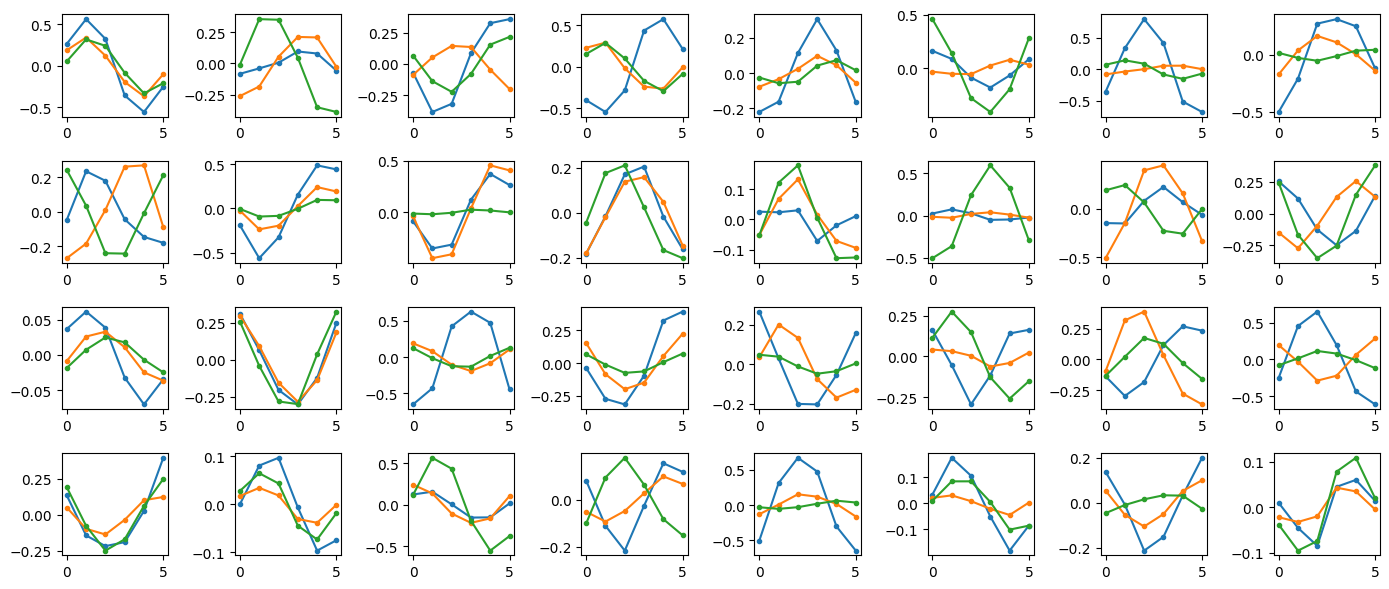

In [9]:
plt.figure(figsize = (14, 6))

count = 0
for i in range(32):
    count += 1
    plt.subplot(4, 8, count)
    for k in range(args.num_items):
        plt.plot(betas[k * args.num_targets : (k + 1) * args.num_targets, i], marker = 'o', markersize = 3)
    # plt.ylim((betas.min(), betas.max()))
    # plt.xticks([])
    # plt.yticks([])

plt.tight_layout()
plt.show()

In [10]:
from sklearn.decomposition import PCA

# divide into 3 groups (rank-r subspaces)
group_size = 6
beta_groups = [betas[i * group_size : (i + 1) * group_size] for i in range(3)]

Vr_hat_list = []
Vr_list = []
kappa_list = []

for r, beta_group in enumerate(beta_groups):
    # demean beta
    beta_mean = np.mean(beta_group, axis = 0) # (6, 32)
    beta_demeaned = beta_group - beta_mean  # (6, 32)

    # PCA
    pca = PCA(n_components = 2)
    pca.fit(beta_demeaned)
    Vr_hat = pca.components_.T # (32, 2), norm = 1
    Vr = Vr_hat * np.sqrt(Vr_hat.shape[0])
    kappa = np.dot(beta_demeaned, Vr) # (6, 2)

    # store results
    Vr_hat_list.append(Vr_hat)
    Vr_list.append(Vr)
    kappa_list.append(kappa)

# output the normalized components V̂r and the projections κ(r, l)
for r, (Vr_hat, kappa) in enumerate(zip(Vr_hat_list, kappa_list), start = 1):
    print(f"Rank-{r} Normalized Basis (V̂r):\n", Vr_hat)
    print(f"Rank-{r} Projected Coordinates (κ(r, l)):\n", kappa)

Rank-1 Normalized Basis (V̂r):
 [[ 0.23739797  0.31297379]
 [ 0.00491599 -0.0680044 ]
 [-0.22563795 -0.1223475 ]
 [-0.21060248 -0.36990671]
 [ 0.04156956 -0.19604487]
 [-0.03018173  0.12004722]
 [ 0.45085537 -0.12732092]
 [ 0.05654877 -0.30132877]
 [ 0.1239076   0.04467043]
 [-0.27810892 -0.2221106 ]
 [-0.20473224 -0.14346886]
 [ 0.08596881 -0.11319045]
 [ 0.00485769  0.02957033]
 [ 0.02285724  0.03634919]
 [ 0.01729346 -0.13675102]
 [-0.04302852  0.18202692]
 [ 0.02907049  0.03532386]
 [-0.09510839  0.20922663]
 [ 0.11169635 -0.5242892 ]
 [-0.22552169 -0.04836979]
 [-0.08426059  0.1506049 ]
 [-0.13244112  0.06064853]
 [-0.14806218 -0.13627288]
 [ 0.39837595 -0.02763038]
 [-0.15987619  0.08562737]
 [ 0.05820926  0.0223942 ]
 [ 0.02665746  0.12316336]
 [-0.10904081 -0.00081178]
 [ 0.39509025 -0.20658824]
 [ 0.08338788  0.07217193]
 [-0.10191475  0.08803051]
 [-0.03264807 -0.02091965]]
Rank-1 Projected Coordinates (κ(r, l)):
 [[-2.5899703   7.23325306]
 [ 6.44245718  5.46158533]
 [ 9.250

In [11]:
def compute_principal_angles(Va, Vb):
    # compute the inner product matrix
    M = np.dot(Va.T, Vb)  # (2, 2)

    # SVD
    U, singular_values, Vt = np.linalg.svd(M)

    # compute the principal angles (in degrees)
    principal_angles = np.arccos(np.clip(singular_values, -1.0, 1.0)) * (180 / np.pi)

    return principal_angles[0]

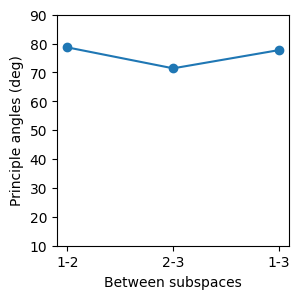

In [12]:
angles = [
    compute_principal_angles(Vr_hat_list[0], Vr_hat_list[1]),
    compute_principal_angles(Vr_hat_list[1], Vr_hat_list[2]),
    compute_principal_angles(Vr_hat_list[0], Vr_hat_list[2]),
]

plt.figure(figsize = (3, 3))
plt.plot(angles, marker = 'o')
plt.xticks(ticks = [0, 1, 2], labels = ['1-2', '2-3', '1-3'])
plt.ylim((10, 90))
plt.xlabel('Between subspaces')
plt.ylabel('Principle angles (deg)')
plt.show()

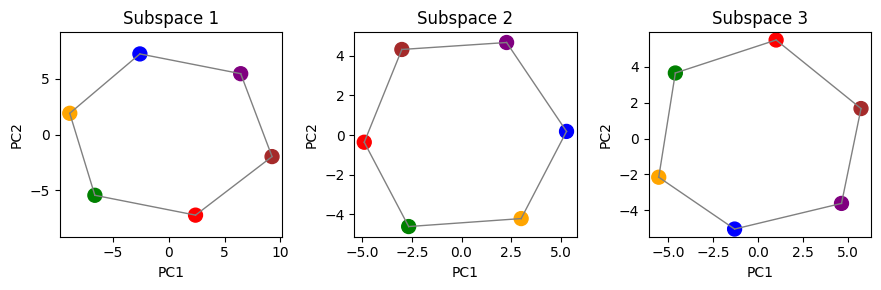

In [13]:
plt.figure(figsize = (9, 3))
for j in range(3):
    kappa = kappa_list[j]

    plt.subplot(1, 3, j + 1)
    plt.scatter(kappa[:, 0], kappa[:, 1], c = ['blue', 'purple', 'brown', 'red', 'green', 'orange'], s = 100)
    for i in range(len(kappa)):
        next_i = (i + 1) % len(kappa)
        plt.plot([kappa[i, 0], kappa[next_i, 0]], [kappa[i, 1], kappa[next_i, 1]], color = 'gray', linewidth = 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Subspace %.0f' % (j + 1), fontsize = 12, loc = 'center')
    # plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    # plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axis('equal')
plt.tight_layout()
plt.show()